In [20]:
## -------------------------- ##
## ---- Import libraries ---- ##
## -------------------------- ##
    
import numpy as np
import pandas as pd
import glob
import re
import os
from scipy.signal import find_peaks, argrelextrema
import matplotlib.pyplot as plt
import tifffile as tf
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


## -------------------------- ##
## ---- Define variables ---- ##
## -------------------------- ##

# Specify the master path (a folder containing subfolders, each containing block repetition maps calculated using a specific test image using and all reference blocks)
# For example, the master folder "/user/spectrin/optimization/sred/" would contain subfolders named "001", "002", (...).
# Each subfolder (e.g., "001") would contain image files (in TIFF format), which are repetition maps calculated for a given test sample.
# The repetition maps are named "sred_X_Y.tif" where "X" and "Y" are the inter-ring spacings and ring heights, in pixels (e.g., "sred_12_33.tif").
folders_path = '/Users/ammendes/spectrin/Optimization/CTRL/sred/'

# Get list of subfolders containing repetition maps for each input image
folderlist = os.listdir(folders_path)
pattern = r'(\d{3})'
folderlist = [folder for folder in folderlist if re.match(pattern, folder)]
folderlist = sorted(folderlist, key=lambda x: (int(re.findall(r"\d+", x)[0])))

# Create dataframe to store heatmap results
final_df = pd.DataFrame(columns=['max_amplitude', 'spacing', 'height'])

for folder in range(len(folderlist)):
    
    print('Processing folder ', str(folder+1) + '/' + str(len(folderlist)))

    # Specify the folder path containing repetition maps
    input_path = folders_path + '/' + folderlist[folder] + '/' 
    output_path = folders_path + '/' + folderlist[folder] + '/autocorrelations/' # This is where the autocorrelation results will be stored
    os.makedirs(output_path, exist_ok=True) # Create path if it doesn't exist

    # Get file list
    filelist = os.listdir(input_path)

    # Define regular expression pattern to match files with the correct format
    pattern = r'sred_(\d{1,2})_(\d{1,2})\.tif'

    # Filter files based on name pattern, excluding files that don't match the pattern
    filelist = [file for file in filelist if re.match(pattern, file)]

    # Sort the files based on the values in the name
    filelist = sorted(filelist, key=lambda x: (int(re.findall(r"\d+", x)[0]), int(re.findall(r"\d+", x)[1])))

    # Create table to store results
    results = pd.DataFrame(columns=['Spacing (µm)', 'Height (µm)', 'First Harmonic Position (µm)', 'First Harmonic Relative Amplitude'])

    # Define pixel size
    calibration_factor = 0.016


    ## ------------------------------------ ##
    ## ---- Calculate autocorrelations ---- ##
    ## ------------------------------------ ##

    print('Calculating autocorrelations...')
    for file in range(len(filelist)):
        print(str(file+1)+'/'+str(len(filelist)))
        
        # Import image
        image = tf.imread(input_path + filelist[file])
        image = np.square(image) # Apply non-linear mapping to enhance structural features

        # Define region of interest (entire image in our case)
        x1, y1 = 0, 0  # top-left corner
        x2, y2 = image.shape[1], image.shape[0]  # bottom-right corner

        # Get inter-ring spacing and ring height from file names
        match = re.match(pattern, filelist[file])
        spacing = int(match.group(1))
        height = int(match.group(2))

        # Get intensity profile
        intensity_profile = np.sum(image[y1:y2, x1:x2], axis=0)

        # Create x-axis representing pixel position
        x_axis_original = np.arange(x1, x2)

        # Calculate the autocorrelation of the intensity profile
        autocorrelation = np.correlate(intensity_profile, intensity_profile, mode='full')
        autocorrelation /= np.max(autocorrelation)  # Normalize

        # Keep only the right half of the autocorrelation
        lag = np.arange(-len(intensity_profile) + 1, len(intensity_profile))

        # Create the lag (x-axis) for the autocorrelation in micrometers
        lag_pixels = np.arange(-len(intensity_profile) + 1, len(intensity_profile))
        lag_um = lag_pixels * calibration_factor

        # Keep only the right half (positive lag) of the autocorrelation
        positive_lag_indices = lag_pixels >= 0
        lag_positive = lag_um[positive_lag_indices]
        autocorrelation_positive = autocorrelation[positive_lag_indices]

        # Interpolate autocorrelation to make it continuous
        interp_func_auto = interp1d(lag_positive, autocorrelation_positive, kind='cubic')
        lag_positive = np.linspace(min(lag_positive), max(lag_positive), 2000)
        autocorrelation_positive = interp_func_auto(lag_positive)

        # Smooth the interpolated autocorrelation using a Gaussian filter (removes some unwanted noise)
        sigma = 1.0
        autocorrelation_positive = gaussian_filter1d(autocorrelation_positive, sigma)

        # Find local maxima in the autocorrelation
        peaks, _ = find_peaks(autocorrelation_positive, prominence = 0.005)

        # Find local minima in the autocorrelation
        minima_indices = argrelextrema(autocorrelation_positive, np.less)

        # Check if local maxima and minima were found
        if len(peaks) > 0 and len(minima_indices[0]) > 0:
            # Calculate the position of the first local maximum in micrometers
            first_peak_um = lag_positive[peaks[0]]

            # Find the nearest local minimum to the left of the first peak
            left_minima = minima_indices[0][minima_indices[0] < peaks[0]]
            if len(left_minima) > 0:
                nearest_left_minima = left_minima[-1]
            else:
                nearest_left_minima = minima_indices[0][0]

            # Find the nearest local minimum to the right of the first peak
            right_minima = minima_indices[0][minima_indices[0] > peaks[0]]
            if len(right_minima) > 0:
                nearest_right_minima = right_minima[0]
            else:
                nearest_right_minima = minima_indices[0][-1]

            # Calculate the average of the two nearest local minima
            avg_minima_height = (autocorrelation_positive[nearest_left_minima] + autocorrelation_positive[nearest_right_minima]) / 2.0

            # Calculate the height of the first harmonic by subtracting its height from the average of the minima
            peak_height = autocorrelation_positive[peaks[0]]
            relative_peak_height = peak_height - avg_minima_height

            # Add results to table
            results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,
                                                        'Height (µm)': height * calibration_factor,
                                                        'First Harmonic Position (µm)': [first_peak_um],
                                                        'First Harmonic Relative Amplitude': [relative_peak_height]})],
                                                        ignore_index=True)

            # Plot the right half of the normalized autocorrelation with the local maxima and minima around the first harmonic highlighted
            plt.plot(lag_positive, autocorrelation_positive)
            plt.plot(first_peak_um, peak_height, 'mo', label='First Harmonic')
            plt.plot(lag_positive[nearest_left_minima], autocorrelation_positive[nearest_left_minima], 'go', label='Local Minima')
            plt.plot(lag_positive[nearest_right_minima], autocorrelation_positive[nearest_right_minima], 'go')

            plt.xlabel('Distance (µm)')
            plt.ylabel('Normalized Autocorrelation')
            plt.title('Normalized Autocorrelation of Intensity Profile')
            plt.xlim(0, 1.5)
            plt.legend()
            plt.grid()

            # Save plot to folder
            plt.savefig(f'{output_path}autocorrelation_{spacing}_{height}.png', dpi=300)  # Customize the filename as needed
            plt.close('all')

            # Print the first harmonic's position and amplitude
            print("First Harmonic position:", first_peak_um, "µm")
            print("First Harmonic amplitude:", relative_peak_height)
        else:
            print("No local maxima or minima were found in the autocorrelation.")
            new_row_data = {
                'Spacing (µm)': spacing * calibration_factor,
                'Height (µm)': height * calibration_factor,
                'First Harmonic Position (µm)': 0.0,
                'First Harmonic Relative Amplitude': 0.0
            }

            new_row_df = pd.DataFrame(new_row_data, index=[len(results)])

            results = pd.concat([results, new_row_df], ignore_index=True)

            # Plot the right half of the normalized autocorrelation with the local maxima and minima around the first harmonic highlighted
            plt.plot(lag_positive, autocorrelation_positive)
            #plt.plot(first_peak_um, peak_height, 'mo', label='First Harmonic')
            #plt.plot(lag_positive[nearest_left_minima], autocorrelation_positive[nearest_left_minima], 'go', label='Local Minima')
            #plt.plot(lag_positive[nearest_right_minima], autocorrelation_positive[nearest_right_minima], 'go')

            plt.xlabel('Distance (µm)')
            plt.ylabel('Normalized Autocorrelation')
            plt.title('Normalized Autocorrelation of Intensity Profile')
            plt.xlim(0, 1.5)
            plt.legend()
            plt.grid()
            #plt.show()

            # Save plot to folder
            plt.savefig(f'{output_path}autocorrelation_{spacing}_{height}.png', dpi=300)  # Customize the filename as needed
            plt.close('all')

    # Save results to CSV
    results.to_csv(output_path+'results.csv', index=False)


    ## -------------------------- ##
    ## ---- Generate heatmap ---- ##
    ## -------------------------- ##

    print('Generating heatmap...')

    # Read the CSV file into a DataFrame
    df = pd.read_csv(output_path + 'results.csv')

    # Pivot the DataFrame to create the heatmap data
    heatmap_data = pd.pivot_table(df, values='First Harmonic Relative Amplitude', index='Height (µm)', columns='Spacing (µm)')

    # Create the heatmap
    plt.figure(figsize=(10, 9))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', origin='lower', 
               extent=[heatmap_data.columns.min()-0.015, heatmap_data.columns.max()+0.015,
                       heatmap_data.index.min()-0.015, heatmap_data.index.max()+0.015])

    colorbar = plt.colorbar(label='First Harmonic Relative Amplitude')
    colorbar.ax.yaxis.label.set_fontsize(18)
    colorbar.ax.yaxis.labelpad = 12

    plt.xlabel('Line spacing (µm)', fontsize=18, labelpad=12)
    plt.ylabel('Line height (µm)', fontsize=18, labelpad=12)
    plt.title('Autocorrelation analysis', fontsize=18, pad=12)

    # Calculate and set custom tick positions and labels based on data range
    x_ticks = np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), heatmap_data.shape[1])
    y_ticks = np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), heatmap_data.shape[0])

    plt.xticks(x_ticks, [f'{x:.3f}' for x in x_ticks], rotation=25)
    plt.yticks(y_ticks, [f'{y*0.7:.3f}' for y in y_ticks])

    #plt.show()
    plt.savefig(output_path + 'heatmap.png', dpi=300)
    plt.close('all')

    # Calculate heatmap maximum value
    max_amplitude = heatmap_data.max().max()
    
    # Find the optimised parameter values
    values = heatmap_data.stack().idxmax()
    
    # Store values in dataframe
    final_df.loc[folder] = [max_amplitude, values[1], values[0]]
    
    print('Done.')
    print('')


## ------------------------------ ##
## ---- Save heatmap results ---- ##
## ------------------------------ ##

final_df.to_csv(folders_path+'heatmap_data.csv', index=False)
    
print('Done!')

Processing folder  1/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  2/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  3/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  4/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that a

Generating heatmap...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:172: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_df], ignore_index=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done.

Processing folder  5/30
Calculating autocorrelations...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Generating heatmap...
Done.

Processing folder  6/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  7/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  8/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  9/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  10/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  11/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  12/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  13/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  14/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  15/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  16/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  17/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  18/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  19/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  20/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:172: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_df], ignore_index=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done.

Processing folder  21/30
Calculating autocorrelations...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Generating heatmap...
Done.

Processing folder  22/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  23/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  24/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  25/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that a

Generating heatmap...
Done.

Processing folder  26/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  27/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  28/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  29/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,


Generating heatmap...
Done.

Processing folder  30/30
Calculating autocorrelations...


/var/folders/_k/plj42bld54n7y_37wjz3qvt00000gp/T/ipykernel_12616/3117465453.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Spacing (µm)': spacing * calibration_factor,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that a

Generating heatmap...
Done.

Finished!


## Now we can calculate some statistics!


In [9]:
import pandas as pd

# Get CTRL data
ctrl_data = pd.read_csv('/Users/user/Optimization/CTRL/sred/heatmap_data.csv') # Change accordingly

ctrl_amplitude_median = ctrl_data['max_amplitude'].median()
ctrl_amplitude_mean = ctrl_data['max_amplitude'].mean()
ctrl_amplitude_std = ctrl_data['max_amplitude'].std()

ctrl_spacing_median = ctrl_data['spacing'].median()
ctrl_spacing_mean = ctrl_data['spacing'].mean()
ctrl_spacing_std = ctrl_data['spacing'].std()

ctrl_height_median = ctrl_data['height'].median()
ctrl_height_mean = ctrl_data['height'].mean()
ctrl_height_std = ctrl_data['height'].std()

# Get SWIN data
swin_data = pd.read_csv('/Users/user/Optimization/SWIN/sred/heatmap_data.csv') # Change accordingly

swin_amplitude_median = swin_data['max_amplitude'].median()
swin_amplitude_mean = swin_data['max_amplitude'].mean()
swin_amplitude_std = swin_data['max_amplitude'].std()

swin_spacing_median = swin_data['spacing'].median()
swin_spacing_mean = swin_data['spacing'].mean()
swin_spacing_std = swin_data['spacing'].std()

swin_height_median = swin_data['height'].median()
swin_height_mean = swin_data['height'].mean()
swin_height_std = swin_data['height'].std()


In [24]:
from scipy.stats import mannwhitneyu

# Mann-Whitney test on inter-ring spacings
mannwhitneyu_result = mannwhitneyu(ctrl_data['spacing'], swin_data['spacing'], alternative='two-sided')
print('Mann-Whitbey U Test on spacings: ', mannwhitneyu_result)


Mann-Whitbey U Test on spacings:  MannwhitneyuResult(statistic=362.5, pvalue=0.18323879424279654)


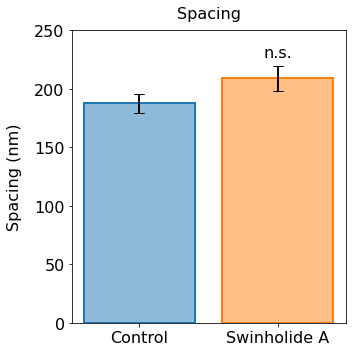

In [25]:
## ---------------------------------- ##
## ---- Plot inter-ring spacings ---- ##
## ---------------------------------- ##

# Prepare data
import math
from matplotlib.ticker import FuncFormatter

groups = ['Control', 'Swinholide A']
means = [ctrl_data['spacing'].mean(), swin_data['spacing'].mean()]
sems = [ctrl_data['spacing'].std()/math.sqrt(len(ctrl_data['spacing'])),
        swin_data['spacing'].std()/math.sqrt(len(swin_data['spacing']))]

# Create an array for the x-axis positions of bars
x = np.arange(len(groups))

# Create the bar plot
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(5, 5))  # Width, height in inches

for i in range(len(groups)):
    plt.bar(x[i], means[i], yerr=sems[i], capsize=5, alpha=1, label='Means', color='white', edgecolor=colors[i], linewidth=2)
    plt.bar(x[i], means[i], yerr=sems[i], capsize=5, alpha=0.5, label='Means', color=colors[i])

# Customize plot
plt.title('Spacing', fontsize=16, pad=12)
plt.xticks(x, groups, fontsize=16)  # Set group labels on the x-axis
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Spacing (nm)', fontsize=16, labelpad=12)


def y_format_func(value, tick_number):
    new_value = value * 1000
    return f"{new_value:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format_func))

plt.ylim(0, 0.25)

# Add "n.s." label on top of the 2nd (Swin) and 3rd (Cuc) bars
plt.text(x[1], means[1] + sems[1] + 0.005, 'n.s.', ha='center', va='bottom', color='black', fontsize=16)

# Show the plot
plt.tight_layout()
plt.savefig('/Users/user/Optimization/optimized_spacings.png', dpi=300)

#plt.show()


In [ ]:
# STATS ON HEIGHTS



In [26]:
# Mann-Whitney test on ring heights
from scipy.stats import mannwhitneyu

mannwhitneyu_result = mannwhitneyu(ctrl_data['height'], swin_data['height'], alternative='two-sided')
print('Mann-Whitbey U Test on heights: ', mannwhitneyu_result)


Mann-Whitbey U Test on heights:  MannwhitneyuResult(statistic=482.0, pvalue=0.6374445582766697)


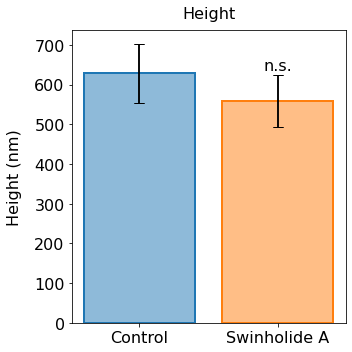

In [28]:
## --------------------------- ##
## ---- Plot ring heights ---- ##
## --------------------------- ##

# Prepare data
import math
from matplotlib.ticker import FuncFormatter

groups = ['Control', 'Swinholide A']
means = [ctrl_data['height'].mean(), swin_data['height'].mean()]
sems = [ctrl_data['height'].std()/math.sqrt(len(ctrl_data['height'])),
        swin_data['height'].std()/math.sqrt(len(swin_data['height']))]

# Create an array for the x-axis positions of bars
x = np.arange(len(groups))

# Create the bar plot
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(5, 5))  # Width, height in inches

for i in range(len(groups)):
    plt.bar(x[i], means[i], yerr=sems[i], capsize=5, alpha=1, label='Means', color='white', edgecolor=colors[i], linewidth=2)
    plt.bar(x[i], means[i], yerr=sems[i], capsize=5, alpha=0.5, label='Means', color=colors[i])

# Customize plot
plt.title('Height', fontsize=16, pad=12)
plt.xticks(x, groups, fontsize=16)  # Set group labels on the x-axis
plt.tick_params(axis='y', labelsize=16)
plt.yticks()
plt.ylabel('Height (nm)', fontsize=16, labelpad=12)


def y_format_func(value, tick_number):
    new_value = value * 1000
    return f"{new_value:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format_func))

#plt.ylim(0, 1.2)

# Add "n.s." label on top of the 2nd (Swin) and 3rd (Cuc) bars
plt.text(x[1], means[1] + sems[1] + 0.005, 'n.s.', ha='center', va='bottom', color='black', fontsize=16)

# Show the plot
plt.tight_layout()
plt.savefig('/Users/ammendes/Library/CloudStorage/OneDrive-igc.gulbenkian.pt/Mendes_2023/Data_Leterrier_spectrin/Optimization/optimized_heights.png', dpi=300)

#plt.show()




In [ ]:
# STATS ON AMPLITUDES

In [29]:
# Mann-Whitney test on amplitudes
from scipy.stats import mannwhitneyu

mannwhitneyu_result = mannwhitneyu(ctrl_data['max_amplitude'], swin_data['max_amplitude'], alternative='two-sided')
print('Mann-Whitbey U Test on amplitudes: ', mannwhitneyu_result)


Mann-Whitbey U Test on amplitudes:  MannwhitneyuResult(statistic=598.0, pvalue=0.029205409568445008)


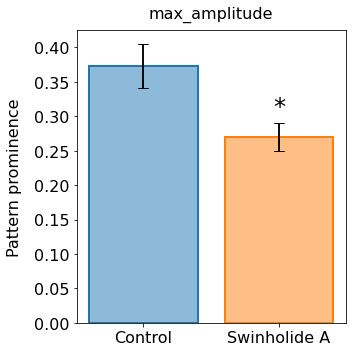

In [8]:
## ------------------------- ##
## ---- Plot amplitudes ---- ##
## ------------------------- ##

# Prepare data
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

groups = ['Control', 'Swinholide A']
means = [ctrl_data['max_amplitude'].mean(), swin_data['max_amplitude'].mean()]
sems = [ctrl_data['max_amplitude'].std()/math.sqrt(len(ctrl_data['max_amplitude'])),
        swin_data['max_amplitude'].std()/math.sqrt(len(swin_data['max_amplitude']))]

# Create an array for the x-axis positions of bars
x = np.arange(len(groups))

# Create the bar plot
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(5, 5))  # Width, height in inches

for i in range(len(groups)):
    plt.bar(x[i], means[i], yerr=sems[i], capsize=5, alpha=1, label='Means', color='white', edgecolor=colors[i], linewidth=2)
    plt.bar(x[i], means[i], yerr=sems[i], capsize=5, alpha=0.5, label='Means', color=colors[i])

# Customize plot
plt.title('max_amplitude', fontsize=16, pad=12)

plt.xticks(x, groups, fontsize=16)  # Set group labels on the x-axis

plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Pattern prominence', fontsize=16, labelpad=12)


def y_format_func(value, tick_number):
    new_value = value
    return f"{new_value:.2f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format_func))

#plt.ylim(0, 1)

# Add "n.s." label on top of the 2nd (Swin) and 3rd (Cuc) bars
plt.text(x[1], means[1] + sems[1] + 0.005, '*', ha='center', va='bottom', color='black', fontsize=24)

# Show the plot
plt.tight_layout()
plt.savefig('/Users/ammendes/Library/CloudStorage/OneDrive-igc.gulbenkian.pt/Mendes_2023/Data_Leterrier_spectrin/Optimization/optimized_amplitudes.png', dpi=300)

#plt.show()